# Goal 
1. ap the attention weights of CodeGen to the characters and visualize a heatmap over the source code.
1. visualize the attention weights layer by layer and apply the post-processing of the paper: “Quantifying Attention Flow In Transformers”, ACL 2020.


In [1]:
import os

import numpy as np
from typing import List, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
import torch

import project_path

import matplotlib as mpl
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
MODEL_FOLDER = "../huggingface_models"
HUGGING_FACE_REPO = "Salesforce/codegen-350M-mono"
FOLDER_WITH_SAMPLES = "code_snippet_samples"
PAPER_FOLDER = "../paper/images/"

# Computation of Token-Token Interactions

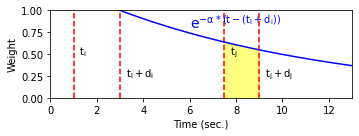

In [16]:
from turtle import color


N_SEC = 10
# plot exponential decay function
t_i = 1
t_i_end = 3
t_j = 7.5
t_j_end = 9
x = np.arange(0, t_i_end + N_SEC, 0.01)
y = np.exp(-0.1*(x - t_i_end))

fig, ax = plt.subplots(figsize=(5, 2))
# annotate exponential decay functionj
ax.text(6, 0.8, "$\mathregular{e^{- \\alpha*(t - (t_i + d_i))}}$", fontsize=14, color="blue")

# draw all the vertical lines
ax.axvline(x=t_i, color="r", linestyle="--")
ax.axvline(x=t_i_end, color="r", linestyle="--")
ax.axvline(x=t_j, color="r", linestyle="--")
ax.axvline(x=t_j_end, color="r", linestyle="--")
ax.text(t_i + 0.25, 0.5, "$\mathregular{t_i}$")
ax.text(t_i_end + 0.25, 0.25, "$\mathregular{t_i + d_i}$")
ax.text(t_j + 0.25, 0.5, "$\mathregular{t_j}$")
ax.text(t_j_end + 0.25, 0.25, "$\mathregular{t_j + d_j}$")



ax.plot(x, y, color="blue")
# fill the plot between the last two vertical lines
ax.fill_between(x, y, 0, where=(x > t_j) & (x < t_j_end), color="yellow", alpha=0.5)
ax.set_xlim(0, t_i_end + N_SEC)
ax.set_ylim(0, 1)
ax.set_ylabel("Weight")
ax.set_xlabel("Time (sec.)")

# save 
plt.tight_layout()
fig.savefig(os.path.join(PAPER_FOLDER, "ex_integral_on_pair_events.pdf"))

# Run Model and get attention weights

In [4]:
from transformers import AutoTokenizer
from attwizard.models.modeling_codegen import CodeGenForCausalLM
from attwizard.script.utils import get_model_folder_path

model_folder_path = get_model_folder_path(
    model_folder=MODEL_FOLDER,
    hugging_short_repo=HUGGING_FACE_REPO
)

if os.path.exists(os.path.join(model_folder_path, "pytorch_model.bin")):
    print("Model loaded locally...")
    tokenizer = AutoTokenizer.from_pretrained(model_folder_path)
    model = CodeGenForCausalLM.from_pretrained(model_folder_path)
    print(model)
else:
    print("You must download the model first with: attwizard.script.download_model.py.")

Model loaded locally...
CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
       

# Visualize BPE Att. as Char-level Att. (GPT-NEO weights)

In [5]:
prompt = open(os.path.join(FOLDER_WITH_SAMPLES, "example.py"), 'r').read()

In [6]:
prompt = """def sum(a, b)"""
print(prompt)

tmp = tokenizer(prompt, return_tensors="pt")
input_ids = tmp['input_ids']
attention_mask = tmp['attention_mask']
torch.manual_seed(37)  # 42

N_NEW_TOKENS = 20

model_output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    do_sample=True,
    max_time=3,
    eos_token_id=tokenizer.eos_token_id,
    temperature=0.9,
    output_attentions=True,
    max_length=len(input_ids[0]) + N_NEW_TOKENS, 
    return_dict_in_generate=True
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def sum(a, b)


In [7]:
tokenizer.eos_token_id

50256

In [8]:
generated_text = tokenizer.decode(model_output["sequences"][0])
print(generated_text)

def sum(a, b) -> int:
    if a == b:
        return a

    d = {1


This view aggreagets all the layers and heads with a max function


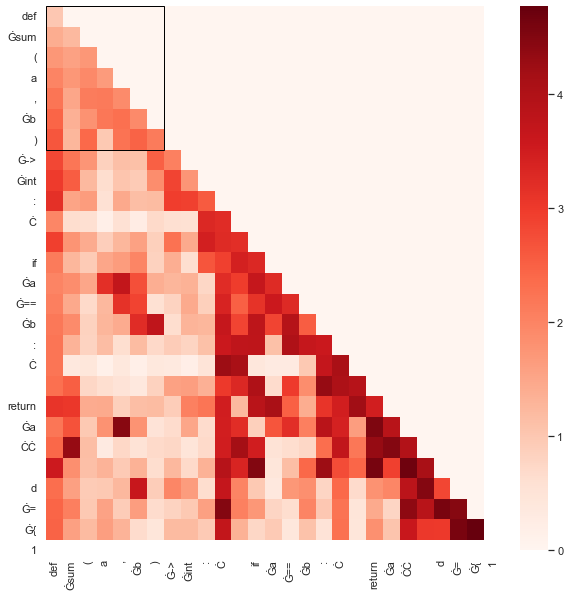

In [12]:
from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize
from attwizard.decoder import normalize_less_attention_on_early_tokens

import torch

tokens_all_attended = tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
tokens_prompt = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_generated = tokens_all_attended[len(tokens_prompt):]

att_tensor = get_attention_tensor(
    model_output=model_output
)
att_tensor = normalize_less_attention_on_early_tokens(
    att_tensor=att_tensor
)
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor)
condensed_att_tensor = \
    condense_attention(
        condensed_att_tensor, 
        reduce_direction="both",
        reduce_function=torch.amax)
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokens_all_attended,
    n_input_tokens=len(tokens_prompt)
)
print("This view aggreagets all the layers and heads with a max function")

# Get Attention on the Last Token Only

In [13]:
tokens_all_attended = tokenizer.convert_ids_to_tokens(model_output["sequences"][0])

In [14]:
from ipywidgets import interact
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

def show_att_map_position(token_pos):
    """Show the attention map of a specific token position."""
    global model_output
    global generated_text
    global tokens_all_attended
    print(f"You see the weights of attention to represent the token: {tokens_all_attended[token_pos]}")
    print(f"This token representation is used to predict all the tokens after this.")
    # extract the weights for that token representation
    att_weights = get_attention_representation(att_matrix, token_pos=token_pos)
    att_weights = list(att_weights.numpy())
    # append 1 because the last token is unattended, it is simply generated 
    # attending the previous ones.
    att_weights.append(0)
    print(len(att_weights))
    # convert the attntion to char level (easier to compare and display)
    att_weights_gpt_neo_char_level = map_to_char_level(
        tokens=tokens_all_attended,
        att_weights=att_weights,
        raw_text=generated_text,
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(generated_text)
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_gpt_neo_char_level,
        show_line_numbers=True
    )
    
gpt_tokens_labels = [
    (t[1], t[0]) for t in list(enumerate(tokens_all_attended))
]    

interact(show_att_map_position, token_pos=gpt_tokens_labels);

interactive(children=(Dropdown(description='token_pos', options=(('def', 0), ('Ġsum', 1), ('(', 2), ('a', 3), …

# Get Attention on Last Token and all the predecessors

In [15]:
from ipywidgets import interact
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

def show_att_map_position_and_predecessors(token_pos):
    """Show the attention map of a specific token position."""
    global model_output
    global generated_text
    global tokens_all_attended
    print(f"You see the weights of attention to represent the token: {tokens_all_attended[token_pos]}")
    print("And all the PREDECESSORS TOKENS as WELL (summed attention)")
    print(f"This token representation is used to predict all the tokens after this.")
    # extract the weights for that token representation
    att_matrix_c_token = att_matrix[:token_pos+1, :]             
    att_weights = att_matrix_c_token.sum(axis=0)  # <----- focus here
    att_weights = list(att_weights.numpy())
    # append 1 because the last token is unattended, it is simply generated 
    # attending the previous ones.
    att_weights.append(0)
    print(len(att_weights))
    # convert the attntion to char level (easier to compare and display)
    att_weights_gpt_neo_char_level = map_to_char_level(
        tokens=tokens_all_attended,
        att_weights=att_weights,
        raw_text=generated_text,
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(generated_text)
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_gpt_neo_char_level,
        show_line_numbers=True
    )
    
gpt_tokens_labels = [
    (t[1], t[0]) for t in list(enumerate(tokens_all_attended))
]    

interact(show_att_map_position_and_predecessors, token_pos=gpt_tokens_labels);

interactive(children=(Dropdown(description='token_pos', options=(('def', 0), ('Ġsum', 1), ('(', 2), ('a', 3), …

# Visualize Layer-Attention

## Prepare Layer-wise Attention: Average of all Heads
Note that, unlike in the heatmap visualization, taking the maximum attention across multiple heads obtains generally large weights for any edge in the network, making it less readable. 
Another valid alternative would be to pick and visualize a single attention head.

In [16]:
from attwizard.decoder import visualize_layer_wise_attention
from attwizard.decoder import get_adjacency_matrix

att_tensor = get_attention_tensor(
    model_output=model_output
)
single_prediction_att_matrix = merge_attention_prompt_and_new_tokens(
    attention_tensor=att_tensor
)
layerwise_att_matrix = condense_attention(
    attention_tensor=single_prediction_att_matrix,
    reduce_direction='head',
    reduce_function=torch.mean    
)
layerwise_att_matrix = layerwise_att_matrix.squeeze()
print("Take the average of the attention heads (to avoid to have too large weights on edges)")
tokens_all_attended = tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
n_tokens = len(tokens_all_attended) -1 
# -1 because the last token is unattended, it is simply generated


Take the average of the attention heads (to avoid to have too large weights on edges)


## Visualize: Raw Attention Weights

In [ ]:
# Set style
rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

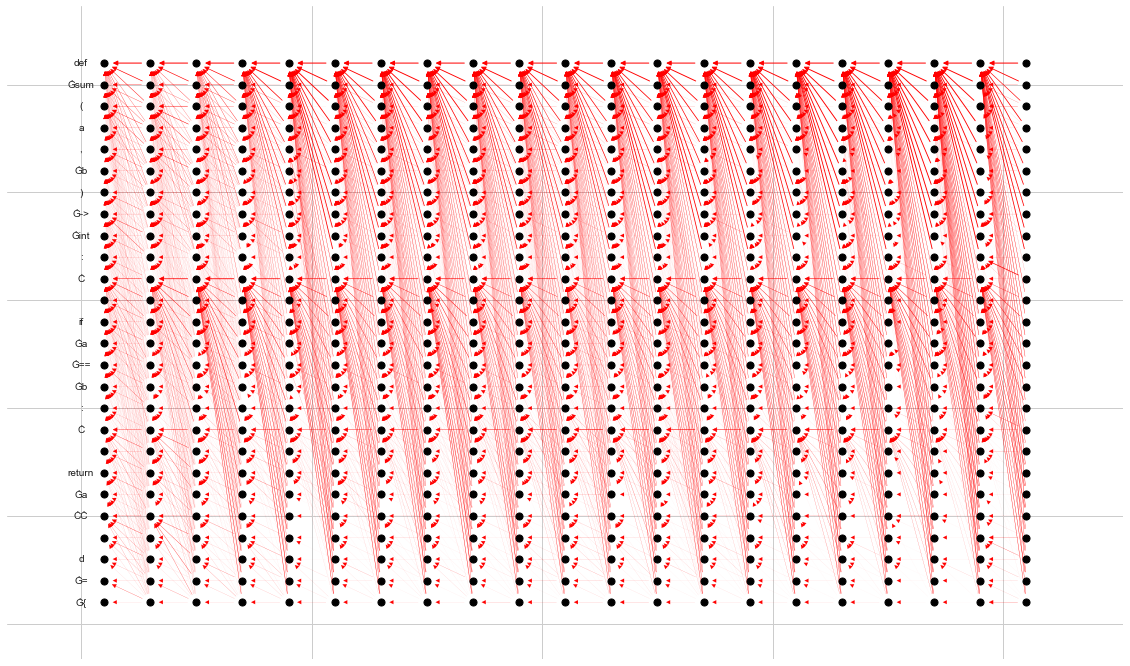

In [23]:
adj_matrix, map_labels_to_token_pos = get_adjacency_matrix(
    att_tensor_layer_by_layer=layerwise_att_matrix,
    input_tokens=tokens_all_attended[:n_tokens]
)   
G_raw_weights, ax = visualize_layer_wise_attention(
    adj_mat=adj_matrix,
    mapping_node_label_to_token_pos=map_labels_to_token_pos,
    n_layers=20,
    n_tokens=n_tokens,
    n_bin_weights=100,
)

fig = plt.gcf()
fig.savefig(os.path.join(PAPER_FOLDER, "att_network_codegen_350_mono.png"))

## Visualize: Residual Connections

In each transformer layer, the embedding of token i becomes a weighted sum (according to the attention weights) of the embedding of the other tokens in the sequence, BUT actually the real output of the transformer layer for token i is this weighted sum PLUS the initial embedding of token i, also called RESIDUAL CONNECTION.

This connection is mostly disregarded by previous work... But “Quantifying Attention Flow In Transformers”, ACL 2020 considers it important.

In the following diagram the RESIDUAL CONNECTIONS (form token i layer x to token i layer x+1) are much more noticeable, and they are more visible than the raw attention weights.


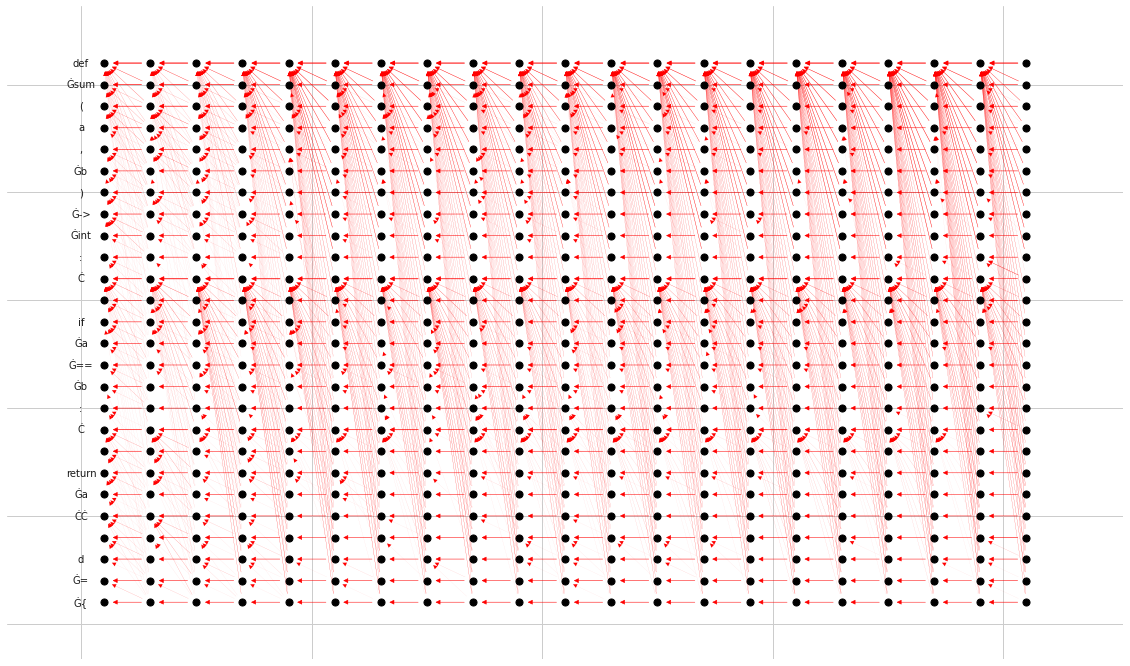

In [16]:
from attwizard.decoder import add_residual_weights

layerwise_att_matrix_with_res_conn = add_residual_weights(att_tensor=layerwise_att_matrix)
adj_matrix, map_labels_to_token_pos = get_adjacency_matrix(
    att_tensor_layer_by_layer=layerwise_att_matrix_with_res_conn,
    input_tokens=tokens_all_attended[:n_tokens]
)
visualize_layer_wise_attention(
    adj_mat=adj_matrix,
    mapping_node_label_to_token_pos=map_labels_to_token_pos,
    n_layers=20,
    n_tokens=n_tokens,
    n_bin_weights=40,
)
print(
    "In the following diagram the RESIDUAL CONNECTIONS " + 
    "(form token i layer x to token i layer x+1) are much more noticeable, and " +
    "they are more visible than the raw attention weights.")

## Visualize: Attention Flow

In [20]:
from attwizard.attention_postprocessing import compute_attention_flow

asj_matrix_flow_values = compute_attention_flow(
    G=G_raw_weights,
    mapping_node_label_to_token_pos=map_labels_to_token_pos,
    n_tokens=n_tokens    
)


(<networkx.classes.digraph.DiGraph at 0x7fcc99c95d60>, <AxesSubplot:>)

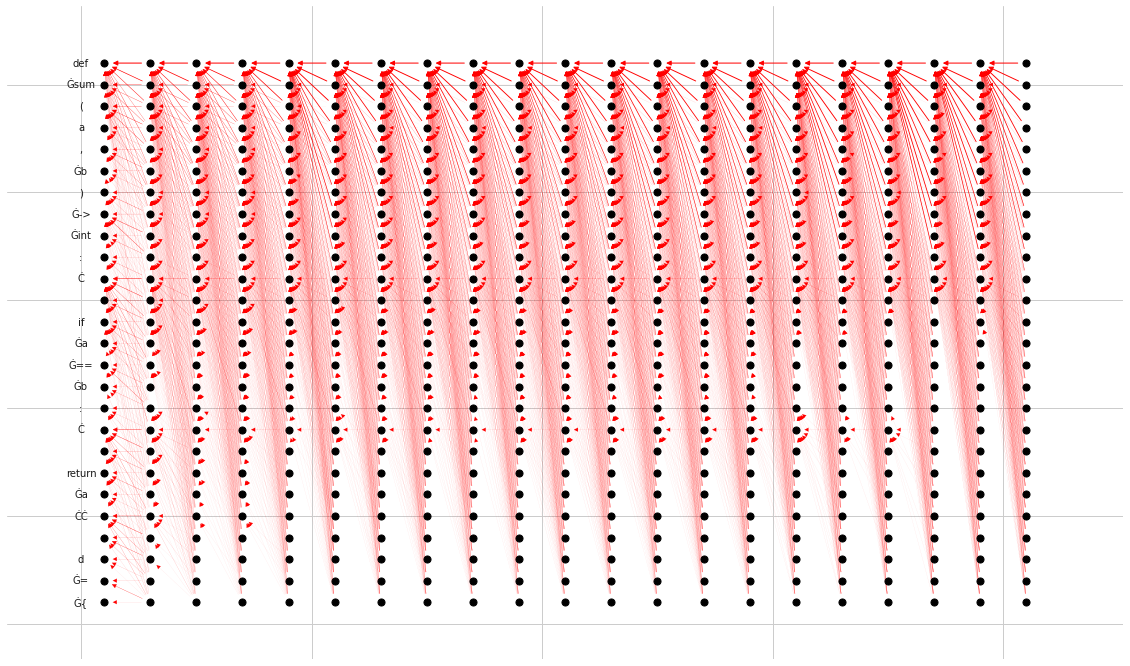

In [21]:
visualize_layer_wise_attention(
    adj_mat=asj_matrix_flow_values,
    mapping_node_label_to_token_pos=map_labels_to_token_pos,
    n_layers=20,
    n_tokens=n_tokens,
    n_bin_weights=40,
)

## Visualize: Attention Rollout

(<networkx.classes.digraph.DiGraph at 0x7fcc99b670a0>, <AxesSubplot:>)

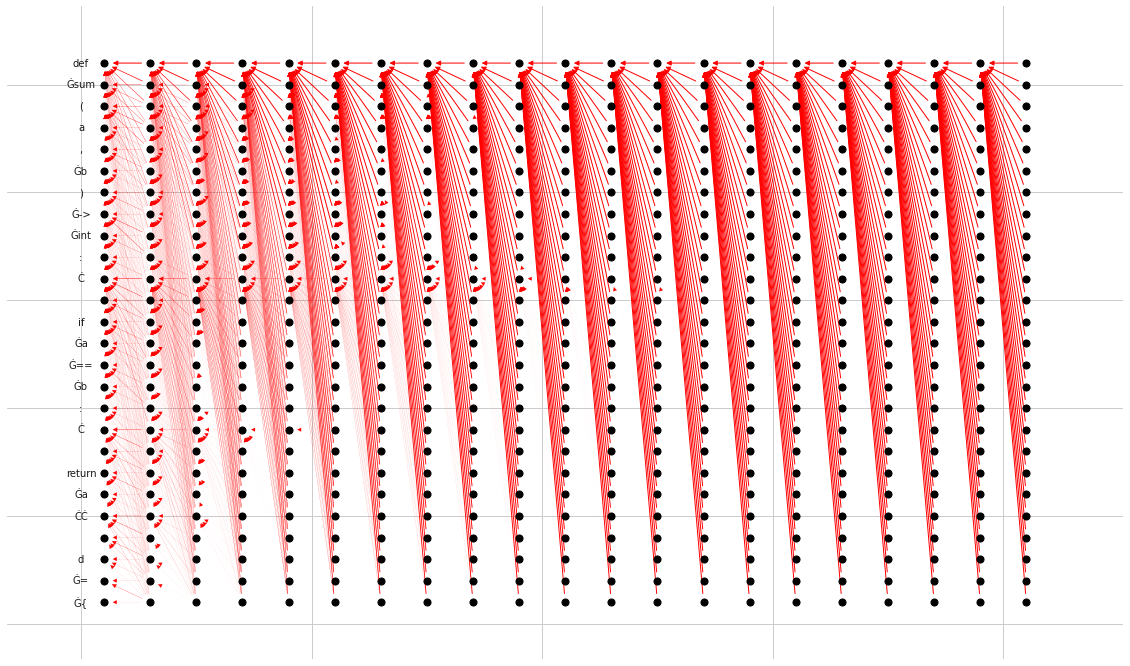

In [23]:
from attwizard.attention_postprocessing import  compute_attention_rollout
layerwise_att_matrix_rollout = compute_attention_rollout(
    layer_wise_att_mat=layerwise_att_matrix,
    add_residual=False
)

adj_matrix, map_labels_to_token_pos = get_adjacency_matrix(
    att_tensor_layer_by_layer=layerwise_att_matrix_rollout,
    input_tokens=tokens_all_attended[:n_tokens]
)
visualize_layer_wise_attention(
    adj_mat=adj_matrix,
    mapping_node_label_to_token_pos=map_labels_to_token_pos,
    n_layers=20,
    n_tokens=n_tokens,
    n_bin_weights=100,
)